## 层次聚类算法 ##

层次聚类(Hierarchical Clustering)是聚类算法的一种，通过计算不同类别数据点间的相似度来创建一棵有层次的嵌套聚类树。

在聚类树中，不同类别的原始数据点是树的最低层，树的顶层是一个聚类的根节点。

创建聚类树有自下而上合并和自上而下分裂两种方法，本篇文章介绍合并方法。

![这里写图片描述](https://imgconvert.csdnimg.cn/aHR0cDovL2ltZy5ibG9nLmNzZG4ubmV0LzIwMTgwMTA3MTY1NTMxNzc4?x-oss-process=image/format,png)

# 层次聚类的合并算法AGNES（凝聚算法）


层次聚类的合并算法通过计算两类数据点间的相似性，对所有数据点中最为相似的两个数据点进行组合，并反复迭代这一过程。

简单的说层次聚类的合并算法是通过计算每一个类别的数据点与所有数据点之间的距离来确定它们之间的相似性，距离越小，相似度越高。

并将距离最近的两个数据点或类别进行组合，生成聚类树。

而当两个数据点进行组合成后，用一个新的代表点，替换原有的两个数据点，再进行下次组合。

其中距离的计算可以使用曼哈顿距离、欧几里得或者皮尔徐相似度进行计算。

**距离的度量包含四种方式 ：**

    (1)最小距离（单链(MIN)）:定义簇的邻近度为不同两个簇的两个最近的点之间的距离。
    
    (2)最大距离（全链(MAX)）:定义簇的邻近度为不同两个簇的两个最远的点之间的距离。
    
    (3)平均距离（组平均）：定义簇的邻近度为取自两个不同簇的所有点对邻近度的平均值。
    
    (4)均值距离（Ward 方法的接近函数）：质心方法通过计算集群的质心之间的距离来计算两个簇的接近度。
    
    对于 Ward 方法来说，两个簇的接近度指的是当两个簇合并时产生的平方误差的增量。
    

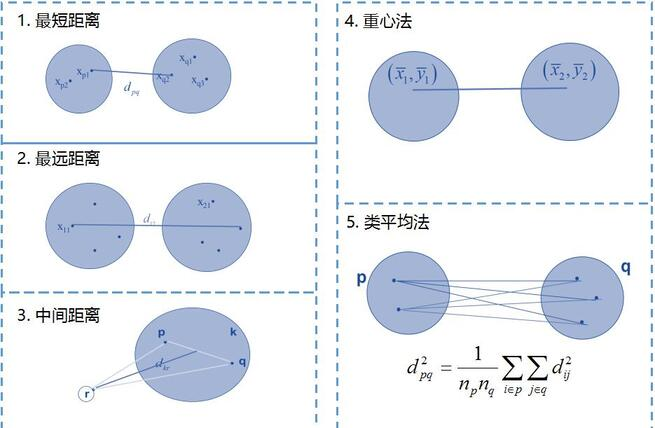

这里我们使用两个数据点的中心位置替换原有数据点。

当然除了凝聚的层次聚类，还有分裂的层次聚类算法DIANA，过程与凝聚的算法相反。

# 层次聚类树状图


将前面的每一步的计算结果以树状图的形式展现出来就是层次聚类树。

最底层是原始A到G的7个数据点。

依照7个数据点间的相似度组合为聚类树的第二层(A,F),(B,C),(D,E)和G。以此类推生成完整的层次聚类树状图。

以下为简单的示意图。

![这里写图片描述](https://imgconvert.csdnimg.cn/aHR0cDovL2ltZy5ibG9nLmNzZG4ubmV0LzIwMTgwMTA3MTcwMDU2MTg1?x-oss-process=image/format,png)

# 加载数据集


使用我们一贯的文本数据集结构。

每行为一个文档（链接或者文档名），每列为一个文档特征（单词），每个单元格的取值为单词在文档中出现的次数。




In [1]:
# 数据集下载
!wget http://luanpeng.oss-cn-qingdao.aliyuncs.com/csdn/python/%E8%81%9A%E7%B1%BB/blogdata.txt

--2022-09-18 10:52:25--  http://luanpeng.oss-cn-qingdao.aliyuncs.com/csdn/python/%E8%81%9A%E7%B1%BB/blogdata.txt
Resolving luanpeng.oss-cn-qingdao.aliyuncs.com (luanpeng.oss-cn-qingdao.aliyuncs.com)... 47.104.37.237
Connecting to luanpeng.oss-cn-qingdao.aliyuncs.com (luanpeng.oss-cn-qingdao.aliyuncs.com)|47.104.37.237|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147123 (144K) [text/plain]
Saving to: ‘blogdata.txt’

blogdata.txt        100%[===================>] 143.67K  --.-KB/s    in 0.1s    

2022-09-18 10:52:25 (1.10 MB/s) - ‘blogdata.txt’ saved [147123/147123]



```
Blog	    china	kids	music	yahoo	want	...
Wonkette	0	    2	    1	    0	    6		...
Publishing  2	    0	    0	    7	    4		...
...			...		...		...		...		...		...
```

```

可以试试运行以下代码完成加载数据集，获取列名，行名，样本数据集

```

In [7]:
# 读取表格型数据，获取特征数据集。
def readfile(filename):
    lines=[line for line in open(filename)]

    # 第一行是列标题
    colnames=lines[0].strip().split('\t')[1:]
    rownames=[]
    data=[]
    for line in lines[1:]:
        p=line.strip().split('\t')
        # 每行的第一列是行名
        rownames.append(p[0])
        # 剩余部分就是该行对应的数据
        onerow = [float(x) for x in p[1:]]
        data.append(onerow)
    return rownames,colnames,data

# 层次聚类构建聚类树


层次聚类构建决策树的过程：

1、将每个样本点都初始化为一个独立的聚类

2、计算数据集中每两个聚类之间的相似度，寻找最相似的两个聚类

3、将最相似的两个聚类化为一个聚类，即用两个聚类的均值点做为新聚类替换原有的两个聚类。

4、重复2、3直到只剩下一个聚类。

这样最后形成的聚类树，每个聚类下都包含左右子聚类。聚类树的叶子节点就是由样本对象初始化来的样本点聚类。

**我们先来创建聚类的面向对象类**

每个聚类都包含左右子聚类，以及代表此聚类的中心点。

另外我们还添加了聚类的id代表聚类在聚类树中的深度，以及左右子聚类的相似度的值。

决策树就是根节点这个聚类。


In [8]:
# 定义一个聚类，包含左右子聚类。
class bicluster:
    def __init__(self,vec,left=None,right=None,distance=0.0,id=None):
        self.left=left    #左子聚类
        self.right=right  #右子聚类
        self.vec=vec      #聚类的中心点
        self.id=id        #聚类的id
        self.distance=distance  #左右子聚类间的距离（相似度）

**计算每个聚类点之间的相似度。**

构建了聚类的类型，我们还要能计算两个聚类的相似度。

我们知道每个聚类都有一个代表该聚类的中心点，我们通过两个聚类的中心点，计算两个聚类的相似度。

在推荐和匹配一章中，我们使用欧氏距离和皮尔逊相似度为例对两个影评者的相似度进行计算。

在文本聚类中，一些博客比其他博客的文章更长一些，包含更多的文章单词。

皮尔逊相似度是判断两个数组与一条直线的拟合程度，因此更适合对两个不同长度的数组进行计算。（两个数组的长度其实是相同的，只是两个数值包含非0值的长度是不同的）

我们使用皮尔逊相似度计算两个中心点的相似度。

In [9]:
# 计算两行的皮尔逊相似度
def pearson(v1,v2):
    # 简单求和
    sum1=sum(v1)
    sum2=sum(v2)

    # 求平方和
    sum1Sq=sum([pow(v,2) for v in v1])
    sum2Sq=sum([pow(v,2) for v in v2])

    # 求乘积之和
    pSum=sum([v1[i]*v2[i] for i in range(len(v1))])

    # 计算r
    num=pSum-(sum1*sum2/len(v1))
    den=sqrt((sum1Sq-pow(sum1,2)/len(v1))*(sum2Sq-pow(sum2,2)/len(v1)))
    if den==0: return 0

    return 1.0-num/den

```

接下面我们就来构建决策树，获取决策树的根节点。

```

In [10]:
# 根据数据集形成聚类树
def hcluster(rows,distance=pearson):
    distance_set={}
    currentclustid=-1

    # 最开始聚类就是数据集中的行，每行一个聚类
    clust=[bicluster(rows[i],id=i) for i in range(len(rows))]   #原始集合中的聚类都设置了不同的正数id，（使用正数是为了标记这是一个叶节点）（使用不同的数是为了建立配对集合）

    while len(clust)>1:
        lowestpair=(0,1)
        closest=distance(clust[0].vec,clust[1].vec)

        # 遍历每一对聚类，寻找距离最小的一对聚类
        for i in range(len(clust)):
            for j in range(i+1,len(clust)):
                # 用distance_set来缓存距离最小的计算值
                if (clust[i].id,clust[j].id) not in distance_set:
                    distance_set[(clust[i].id,clust[j].id)]=distance(clust[i].vec,clust[j].vec)

                d=distance_set[(clust[i].id,clust[j].id)]

                if d<closest:
                    closest=d
                    lowestpair=(i,j)

        # 计算距离最近的两个聚类的平均值作为代表新聚类的中心点
        mergevec=[(clust[lowestpair[0]].vec[i]+clust[lowestpair[1]].vec[i])/2.0 for i in range(len(clust[0].vec))]

        # 将距离最近的两个聚类合并成新的聚类
        newcluster=bicluster(mergevec,left=clust[lowestpair[0]],
                             right=clust[lowestpair[1]],
                             distance=closest,id=currentclustid)

        # 不再原始集合中的聚类id设置为负数。为了标记这是一个枝节点
        currentclustid-=1
        # 删除旧的聚类。（因为旧聚类已经添加为新聚类的左右子聚类了）
        del clust[lowestpair[1]]
        del clust[lowestpair[0]]
        clust.append(newcluster)

    return clust[0]   #返回聚类树

# 绘制决策树


1、获取聚类树要显示完整需要的高度

In [11]:
def getheight(clusttree):
    # 若是叶节点则高度为1
    if clusttree.left==None and clusttree.right==None: return 1

    # 否则，高度为左右分枝的高度之和
    return getheight(clusttree.left)+getheight(clusttree.right)

2、获取聚类树要显示完整需要的深度（宽度）

In [12]:
def getdepth(clusttree):
    # 一个叶节点的距离是0.0
    if clusttree.left==None and clusttree.right==None: return 0

    # 一个叶节点的距离=左右两侧分支中距离较大者 + 该支节点自身的距离
    return max(getdepth(clusttree.left),getdepth(clusttree.right))+clusttree.distance

3、画聚类节点以及子聚类节点

In [13]:
def drawnode(draw,clust,x,y,scaling,labels):
    if clust.id<0:
        h1=getheight(clust.left)*20
        h2=getheight(clust.right)*20
        top=y-(h1+h2)/2
        bottom=y+(h1+h2)/2
        # 线的长度
        ll=clust.distance*scaling
        # 聚类到其子节点的垂直线
        draw.line((x,top+h1/2,x,bottom-h2/2),fill=(255,0,0))

        # 连接左侧节点的水平线
        draw.line((x,top+h1/2,x+ll,top+h1/2),fill=(255,0,0))

        # 连接右侧节点的水平线
        draw.line((x,bottom-h2/2,x+ll,bottom-h2/2),fill=(255,0,0))

        # 调用函数绘制左右子节点
        drawnode(draw,clust.left,x+ll,top+h1/2,scaling,labels)
        drawnode(draw,clust.right,x+ll,bottom-h2/2,scaling,labels)
    else:
        # 如果这是一个叶节点，则绘制节点的标签文本
        draw.text((x+5,y-7),labels[clust.id],(0,0,0))


**接着就可以绘制聚类树**

In [14]:
# 绘制树状图——为每一个最终生成的聚类创建一个高度为20像素，宽度固定的图片。其中缩放因子是由固定宽度除以总的深度得到的
def drawdendrogram(clusttree, labels, jpeg='clusters.jpg'):
    # 高度和宽度
    h = getheight(clusttree) * 20
    w = 1200
    depth = getdepth(clusttree)

    # 由于宽度是固定的，因此我们需要对距离值做相应的调整。（因为显示窗口宽度固定，高度可上下拖动）
    scaling = float(w - 150) / depth

    # 新建一个白色背景的图片
    img = Image.new('RGB', (w, h), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    draw.line((0, h / 2, 10, h / 2), fill=(255, 0, 0))

    # 画根节点（会迭代调用画子节点）
    drawnode(draw, clusttree, 10, (h / 2), scaling, labels)
    img.save(jpeg, 'JPEG')

我们来测试一下

In [17]:
! pip install Pillow

Looking in indexes: https://mirrors.tencent.com/pypi/simple/, https://mirrors.tencent.com/repository/pypi/tencent_pypi/simple


In [16]:
from math import sqrt #导库
from PIL import Image,ImageDraw #导库
blognames,words,data = readfile('blogdata.txt')  #加载数据集
clust = hcluster(data)  #构建聚类树
drawdendrogram(clust,blognames,jpeg='blogclust.jpg')  # 绘制聚类树

![这里写图片描述](https://imgconvert.csdnimg.cn/aHR0cDovL2ltZy5ibG9nLmNzZG4ubmV0LzIwMTgwMTA3MTEzMzIxMjI4?x-oss-process=image/format,png)

一个聚类树就构建完成了。

我们看到这个聚类树还是有明显的分组的。

# 对特征进行聚类


上面的内容我们是对每个对象（也就是每行数据）形成聚类点，然后对聚类点进行聚类。

那么我们是否也可以对每个特征（每列数据）形成聚类点，然后对特征进行聚类，看看哪些单词经常用在一个主题中。

我们只要对特征数据集进行一下转置，让每行为一种特征（单词），每列代表一个对象（文档）。然后再调用上面的层次聚类算法就可以了。

数据集转置代码


In [18]:
# 数据集转置，进行列聚类。
def rotatematrix(data):
    newdata=[]
    for i in range(len(data[0])):
        newrow=[data[j][i] for j in range(len(data))]
        newdata.append(newrow)
    return newdata  #一行表示一个单词在每篇博客中出现的次数


```

下面我们来测试看看

```

In [19]:
blognames,words,data = readfile('blogdata.txt')  #加载数据集
rdata = rotatematrix(data)  #旋转数据集矩阵，对特征属性进行聚类
wordclust = hcluster(rdata) #构建特征的聚类树
drawdendrogram(wordclust,labels=words,jpeg='wordclust.jpg')  # 绘制特征的聚类树

![这里写图片描述](https://imgconvert.csdnimg.cn/aHR0cDovL2ltZy5ibG9nLmNzZG4ubmV0LzIwMTgwMTA3MTIxMTIwODcz?x-oss-process=image/format,png)